In [43]:
import pandas as pd
import numpy as np
import re
import scipy.stats as stats
import matplotlib.pyplot as plt

from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient

configure_offline_feature_store(
    workgroup="primary"
)

In [75]:
data = FeatureStoreOfflineClient.run_athena_query_pandas("""
WITH first_logins     AS (
    SELECT user_id
         , MIN(meta_date) first_login
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start
    GROUP BY user_id
    )
   , login_stats      AS (
    SELECT log.user_id
         , log.meta_date
         , MAX(test_group)  AS test_group
         , MIN(first_login) AS first_login
         , MAX(CASE
                   WHEN first_operating_system = 'Android' THEN 'android'
                   WHEN first_operating_system = 'iOS' THEN 'apple'
                   ELSE 'na' END
        )                   AS os
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start                        log
         INNER JOIN console.clean_abtest                                                  ab
                    ON log.user_id = ab.user_id
                        AND ab.meta_company_id = 'tinysoft-a9kwp'
                        AND ab.meta_project_id = 'heroes-magic-war-h2sln'
         LEFT JOIN  first_logins                                                          fl
                    ON log.user_id = fl.user_id
         LEFT JOIN  etl__tinysoft_a9kwp__heroes_magic_war_h2sln.geo_device_data           geo
                    ON log.user_id = geo.user_id
                        AND log.meta_date = geo.meta_date
         LEFT JOIN  analytics__tinysoft_a9kwp__heroes_magic_war_h2sln.user_exclusion_list uel
                    ON log.user_id = uel.account_id
                        AND log.meta_date BETWEEN uel.date_from AND uel.date_to
    WHERE uel.account_id IS NULL
    GROUP BY log.user_id
           , log.meta_date
    )
   , player_spend     AS (
    SELECT user_id
         , meta_date
         , COALESCE(offer, 'non_personalised')         AS offer
         , MAX(test_group)                             AS test_group
         , SUM(sum_in_app_purchase_event_value_in_usd) AS spend
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.in_app_purchase payments
         INNER JOIN console.clean_abtest                             ab
                    USING (user_id)
         LEFT JOIN  console.tinysoft_offer_store_tmp                 os
                    ON payments.eventpar_product_id = os.offer
    WHERE (ab.meta_company_id = 'tinysoft-a9kwp')
      AND (ab.meta_project_id = 'heroes-magic-war-h2sln')
    GROUP BY user_id
           , meta_date
           , COALESCE(offer, 'non_personalised')
    )

   , win_ratio        AS (
    SELECT *
         , approx_percentile(spend, 0.99) OVER (partition BY meta_date, test_group) AS percentile_threshold
    FROM (
             SELECT user_id
                  , meta_date
                  , test_group
                  , SUM(spend) AS spend
             FROM player_spend
             GROUP BY user_id
                    , meta_date
                    , test_group
             )
    )

   , wins_spend_table AS (
    SELECT user_id
         , meta_date
         , player_spend.*
         , CASE
               WHEN player_spend.spend > percentile_threshold THEN percentile_threshold
               ELSE player_spend.spend END AS wins_spend
    FROM player_spend
         JOIN win_ratio USING (meta_date, user_id)
    )

   , user_level_data  AS (
    SELECT user_id
         , meta_date
         , first_login
         , spend
         , wins_spend
         , os
         , CASE
               WHEN test_group = 'P' THEN 'personalized'
               WHEN test_group = 'C' THEN 'control'
               ELSE 'na' END  group_tag
         , 'Heroes Magic War' client_name
         , CASE
               WHEN offer LIKE 'arena_offer%' THEN 'arena_offer'
               WHEN offer = 'non_personalised' THEN 'non_personalised'
               END offer
    FROM login_stats
         LEFT JOIN wins_spend_table USING (user_id, meta_date, test_group)
    WHERE meta_date >= DATE '2023-01-01'
    )

   , t_out            AS (
    SELECT meta_date
         , offer
         , COUNT(DISTINCT user_id)   AS DAU
         , COUNT(DISTINCT group_tag) AS c_group_tag
         , ((
                    SUM(CASE WHEN group_tag = 'personalized' THEN wins_spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 'personalized' THEN user_id END)
                ) /
            (
                    SUM(CASE WHEN group_tag = 'control' THEN wins_spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 'control' THEN user_id END)
                )) - 1               AS wins_uplift
         , ((
                    SUM(CASE WHEN group_tag = 'personalized' THEN spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 'personalized' THEN user_id END)
                ) /
            (
                    SUM(CASE WHEN group_tag = 'control' THEN spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 'control' THEN user_id END)
                )) - 1               AS uplift
         , SUM(spend)                AS sum_revenue
    FROM user_level_data
    GROUP BY meta_date
           , offer
    HAVING COUNT(DISTINCT group_tag) = 2
    ORDER BY meta_date DESC
           , offer
    )

SELECT *
FROM t_out;
""")
data.head()

DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:191.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:11644.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:3834696942|c


,meta_date,offer,dau,c_group_tag,wins_uplift,uplift,sum_revenue
0,2023-02-25,arena_offer,160,2,-0.595230,-0.595230,2943.816898
1,2023-02-25,non_personalised,157,2,0.019391,0.019391,3463.326787
2,2023-02-25,<NA>,53224,2,NaN,NaN,NaN
3,2023-02-24,arena_offer,146,2,-0.549820,-0.549820,3212.863029
4,2023-02-24,non_personalised,179,2,0.284194,0.284194,4191.257636


In [76]:
for i in data.columns:
    temp_counts = data[[i]].value_counts()
    if len(temp_counts) >= 20 or len(temp_counts) == 1:
        print(i)
        print("# of uniques:", len(temp_counts))
    else:
        display(temp_counts)
    print()

meta_date
# of uniques: 56



offer           
arena_offer         56
non_personalised    56
dtype: int64


dau
# of uniques: 136

c_group_tag
# of uniques: 1

wins_uplift
# of uniques: 112

uplift
# of uniques: 112

sum_revenue
# of uniques: 112



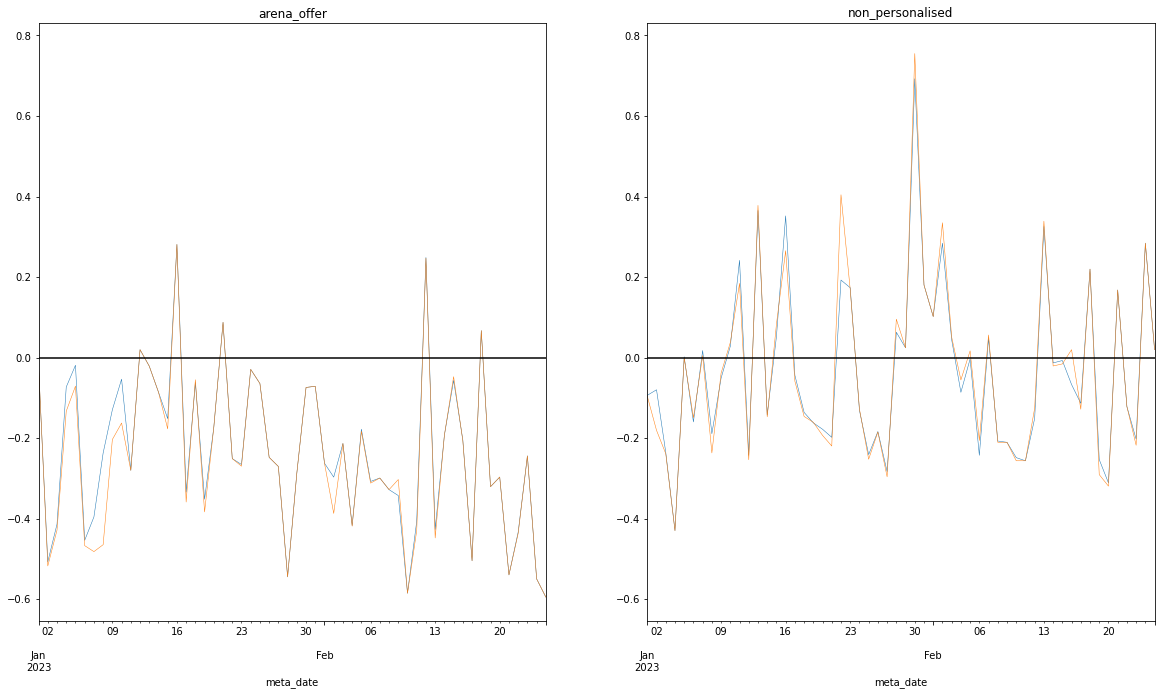

In [126]:
# n_plots = 2

# for i in range(0, n_plots):
#     fig, axes = plt.subplots(nrows = 1, ncols = n_plots, figsize=(20,4))
#     fig.tight_layout()
    
#     for j in range(0, n_plots):
#         offer_name = data.offer.value_counts().index[i*n_plots+j]
#         temp_data = data[data.offer == offer_name].pivot(index = "meta_date", columns = "offer", values = ["wins_uplift", "uplift"])
#         if len(temp_data) > 2:
#             temp_data.plot(legend=None, ax = axes[j], title = offer_name, linewidth = 0.5)
#             axes[j].axhline(y = 0, color = 'black', linewidth = 1.5)

all_ups = [item for sublist in data[['wins_uplift', 'uplift']].values.tolist() for item in sublist]
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20,11))

temp_data = data[data.offer == 'arena_offer'].pivot(index = "meta_date", columns = "offer", values = ["wins_uplift", "uplift"])
temp_data.plot(legend=None, ax = axes[0], title = 'arena_offer', linewidth = 0.5, ylim = [min(all_ups) * 1.1, max(all_ups) * 1.1])
axes[0].axhline(y = 0, color = 'black', linewidth = 1.5)

temp_data = data[data.offer == 'non_personalised'].pivot(index = "meta_date", columns = "offer", values = ["wins_uplift", "uplift"])
temp_data.plot(legend=None, ax = axes[1], title = 'non_personalised', linewidth = 0.5, ylim = [min(all_ups) * 1.1, max(all_ups) * 1.1])
axes[1].axhline(y = 0, color = 'black', linewidth = 1.5)

In [134]:
data2 = FeatureStoreOfflineClient.run_athena_query_pandas("""
WITH first_logins     AS (
    SELECT user_id
         , MIN(meta_date) first_login
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start
    GROUP BY user_id
    )
   , login_stats      AS (
    SELECT log.user_id
         , log.meta_date
         , MAX(test_group)  AS test_group
         , MIN(first_login) AS first_login
         , MAX(CASE
                   WHEN first_operating_system = 'Android' THEN 'android'
                   WHEN first_operating_system = 'iOS' THEN 'apple'
                   ELSE 'na' END
        )                   AS os
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start                        log
         INNER JOIN console.clean_abtest                                                  ab
                    ON log.user_id = ab.user_id
                        AND ab.meta_company_id = 'tinysoft-a9kwp'
                        AND ab.meta_project_id = 'heroes-magic-war-h2sln'
         LEFT JOIN  first_logins                                                          fl
                    ON log.user_id = fl.user_id
         LEFT JOIN  etl__tinysoft_a9kwp__heroes_magic_war_h2sln.geo_device_data           geo
                    ON log.user_id = geo.user_id
                        AND log.meta_date = geo.meta_date
         LEFT JOIN  analytics__tinysoft_a9kwp__heroes_magic_war_h2sln.user_exclusion_list uel
                    ON log.user_id = uel.account_id
                        AND log.meta_date BETWEEN uel.date_from AND uel.date_to
    WHERE uel.account_id IS NULL
    GROUP BY log.user_id
           , log.meta_date
    )
   , player_spend     AS (
    SELECT user_id
         , meta_date
         , COALESCE(offer, 'non_personalised')         AS offer
         , MAX(test_group)                             AS test_group
         , SUM(sum_in_app_purchase_event_value_in_usd) AS spend
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.in_app_purchase payments
         INNER JOIN console.clean_abtest                             ab
                    USING (user_id)
         LEFT JOIN  console.tinysoft_offer_store_tmp                 os
                    ON payments.eventpar_product_id = os.offer
    WHERE (ab.meta_company_id = 'tinysoft-a9kwp')
      AND (ab.meta_project_id = 'heroes-magic-war-h2sln')
    GROUP BY user_id
           , meta_date
           , COALESCE(offer, 'non_personalised')
    )

   , win_ratio        AS (
    SELECT *
         , approx_percentile(spend, 0.99) OVER (partition BY meta_date, test_group) AS percentile_threshold
    FROM (
             SELECT user_id
                  , meta_date
                  , test_group
                  , SUM(spend) AS spend
             FROM player_spend
             GROUP BY user_id
                    , meta_date
                    , test_group
             )
    )

   , wins_spend_table AS (
    SELECT user_id
         , meta_date
         , player_spend.*
         , CASE
               WHEN player_spend.spend > percentile_threshold THEN percentile_threshold
               ELSE player_spend.spend END AS wins_spend
    FROM player_spend
         JOIN win_ratio USING (meta_date, user_id)
    )

   , user_level_data  AS (
    SELECT user_id
         , meta_date
         , first_login
         , COALESCE(spend, 0)      spend
         , COALESCE(wins_spend, 0) wins_spend
         , os
         , CASE
               WHEN test_group = 'P' THEN 1 -- 'personalized'
               WHEN test_group = 'C' THEN 0 -- 'control'
               ELSE 9 END       group_tag
         , 'Heroes Magic War'      client_name
         , CASE
               WHEN offer LIKE 'arena_offer%' THEN 'arena_offer'
               WHEN offer = 'non_personalised' THEN 'non_personalised'
        END                        offer
    FROM login_stats
         LEFT JOIN wins_spend_table USING (user_id, meta_date, test_group)
    WHERE meta_date >= DATE '2023-01-01'
    )
   , data_not_p       AS (
    SELECT meta_date
         , group_tag
         , SUM(spend)      sum_spend_not_p
         , SUM(wins_spend) sum_wins_spend_not_p
    FROM user_level_data
    WHERE offer = 'non_personalised'
    GROUP BY meta_date
           , group_tag
    )
   , data_p           AS (
    SELECT meta_date
         , group_tag
         , SUM(spend)      sum_spend_p
         , SUM(wins_spend) sum_wins_spend_p
    FROM user_level_data
    WHERE offer = 'arena_offer'
    GROUP BY meta_date
           , group_tag
    )
SELECT *
FROM data_not_p
     LEFT JOIN data_p USING (meta_date, group_tag);
""")
data2.head()

DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:243.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:13512.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:3352759545|c


,meta_date,group_tag,sum_spend_not_p,sum_wins_spend_not_p,sum_spend_p,sum_wins_spend_p
0,2023-01-12,0,2659.732798,2621.446898,1412.390935,1412.390935
1,2023-02-22,1,682.039274,682.039274,967.329600,967.329600
2,2023-01-04,1,720.798789,720.798789,1138.978195,1138.978195
3,2023-01-07,0,9160.602383,8982.789302,2161.809207,1853.647202
4,2023-01-29,1,1235.762119,1235.762119,1193.244521,1193.244521


(0.4950569948469546, 2.153126432434212e-08)
(0.47379573757224686, 1.0129811266920049e-07)


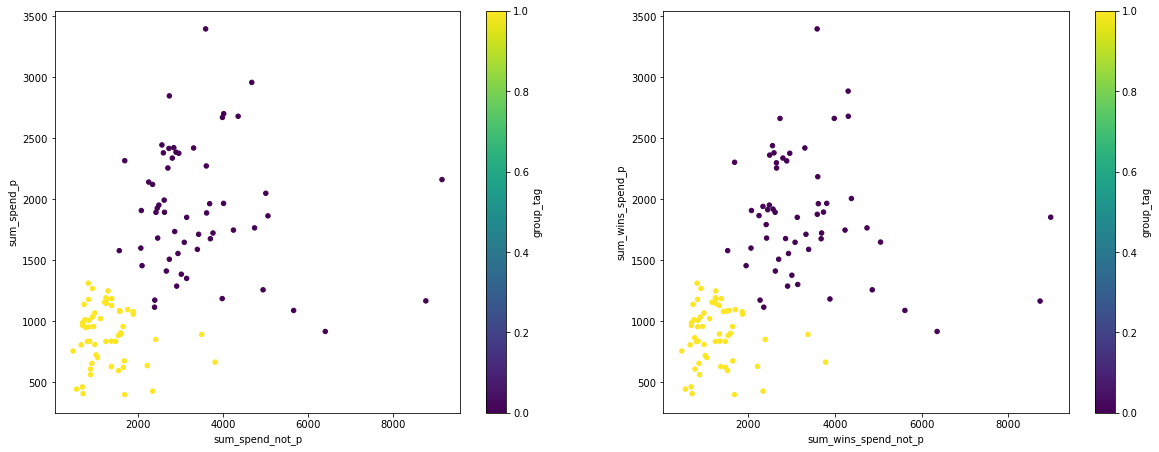

In [168]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 7.4))

data2.plot(kind = 'scatter', x = 'sum_spend_not_p', y = 'sum_spend_p', c = 'group_tag', colormap = 'viridis', ax=axes[0])
data2.plot(kind = 'scatter', x = 'sum_wins_spend_not_p', y = 'sum_wins_spend_p', c = 'group_tag', colormap = 'viridis', ax=axes[1])

print(stats.pearsonr(data2.sum_spend_not_p, data2.sum_spend_p))
print(stats.pearsonr(data2.sum_wins_spend_not_p, data2.sum_wins_spend_p))

In [170]:
data3 = FeatureStoreOfflineClient.run_athena_query_pandas("""
WITH first_logins     AS (
    SELECT user_id
         , MIN(meta_date) first_login
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start
    GROUP BY user_id
    )
   , login_stats      AS (
    SELECT log.user_id
         , log.meta_date
         , MAX(test_group)  AS test_group
         , MIN(first_login) AS first_login
         , MAX(CASE
                   WHEN first_operating_system = 'Android' THEN 'android'
                   WHEN first_operating_system = 'iOS' THEN 'apple'
                   ELSE 'na' END
        )                   AS os
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start                        log
         INNER JOIN console.clean_abtest                                                  ab
                    ON log.user_id = ab.user_id
                        AND ab.meta_company_id = 'tinysoft-a9kwp'
                        AND ab.meta_project_id = 'heroes-magic-war-h2sln'
         LEFT JOIN  first_logins                                                          fl
                    ON log.user_id = fl.user_id
         LEFT JOIN  etl__tinysoft_a9kwp__heroes_magic_war_h2sln.geo_device_data           geo
                    ON log.user_id = geo.user_id
                        AND log.meta_date = geo.meta_date
         LEFT JOIN  analytics__tinysoft_a9kwp__heroes_magic_war_h2sln.user_exclusion_list uel
                    ON log.user_id = uel.account_id
                        AND log.meta_date BETWEEN uel.date_from AND uel.date_to
    WHERE uel.account_id IS NULL
    GROUP BY log.user_id
           , log.meta_date
    )
   , player_spend     AS (
    SELECT user_id
         , meta_date
         , COALESCE(offer, 'non_personalised')         AS offer
         , MAX(test_group)                             AS test_group
         , SUM(sum_in_app_purchase_event_value_in_usd) AS spend
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.in_app_purchase payments
         INNER JOIN console.clean_abtest                             ab
                    USING (user_id)
         LEFT JOIN  console.tinysoft_offer_store_tmp                 os
                    ON payments.eventpar_product_id = os.offer
    WHERE (ab.meta_company_id = 'tinysoft-a9kwp')
      AND (ab.meta_project_id = 'heroes-magic-war-h2sln')
    GROUP BY user_id
           , meta_date
           , COALESCE(offer, 'non_personalised')
    )

   , win_ratio        AS (
    SELECT *
         , approx_percentile(spend, 0.99) OVER (partition BY meta_date, test_group) AS percentile_threshold
    FROM (
             SELECT user_id
                  , meta_date
                  , test_group
                  , SUM(spend) AS spend
             FROM player_spend
             GROUP BY user_id
                    , meta_date
                    , test_group
             )
    )

   , wins_spend_table AS (
    SELECT user_id
         , meta_date
         , player_spend.*
         , CASE
               WHEN player_spend.spend > percentile_threshold THEN percentile_threshold
               ELSE player_spend.spend END AS wins_spend
    FROM player_spend
         JOIN win_ratio USING (meta_date, user_id)
    )

   , user_level_data  AS (
    SELECT user_id
         , meta_date
         , first_login
         , COALESCE(spend, 0)      spend
         , COALESCE(wins_spend, 0) wins_spend
         , os
         , CASE
               WHEN test_group = 'P' THEN 1 -- 'personalized'
               WHEN test_group = 'C' THEN 0 -- 'control'
               ELSE 9 END       group_tag
         , 'Heroes Magic War'      client_name
         , CASE
               WHEN offer LIKE 'arena_offer%' THEN 'arena_offer'
               WHEN offer = 'non_personalised' THEN 'non_personalised'
        END                        offer
    FROM login_stats
         LEFT JOIN wins_spend_table USING (user_id, meta_date, test_group)
    WHERE meta_date >= DATE '2023-01-01'
    )
   , data_not_p       AS (
    SELECT meta_date
         , ((
                    SUM(CASE WHEN group_tag = 1 THEN wins_spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 1 THEN user_id END)
                ) /
            (
                    SUM(CASE WHEN group_tag = 0 THEN wins_spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 0 THEN user_id END)
                )) - 1               AS wins_uplift_not_p
         , ((
                    SUM(CASE WHEN group_tag = 1 THEN spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 1 THEN user_id END)
                ) /
            (
                    SUM(CASE WHEN group_tag = 0 THEN spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 0 THEN user_id END)
                )) - 1               AS uplift_not_p
    FROM user_level_data
    WHERE offer = 'non_personalised'
    GROUP BY meta_date
    )
   , data_p           AS (
    SELECT meta_date
         , ((
                    SUM(CASE WHEN group_tag = 1 THEN wins_spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 1 THEN user_id END)
                ) /
            (
                    SUM(CASE WHEN group_tag = 0 THEN wins_spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 0 THEN user_id END)
                )) - 1               AS wins_uplift_p
         , ((
                    SUM(CASE WHEN group_tag = 1 THEN spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 1 THEN user_id END)
                ) /
            (
                    SUM(CASE WHEN group_tag = 0 THEN spend END) /
                    COUNT(DISTINCT CASE WHEN group_tag = 0 THEN user_id END)
                )) - 1               AS uplift_p
    FROM user_level_data
    WHERE offer = 'arena_offer'
    GROUP BY meta_date
    )
SELECT *
FROM data_not_p
     LEFT JOIN data_p USING (meta_date);
""")
data3.head()

DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:142.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:8715.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:3352901395|c


,meta_date,wins_uplift_not_p,uplift_not_p,wins_uplift_p,uplift_p
0,2023-02-15,-0.007474,-0.015888,-0.056695,-0.047553
1,2023-01-20,-0.178167,-0.193391,-0.173090,-0.173090
2,2023-01-22,0.192413,0.404399,-0.251106,-0.251106
3,2023-02-01,0.101657,0.101657,-0.262622,-0.262622
4,2023-01-12,-0.243022,-0.253919,0.019524,0.019524


(0.09533812651319337, 0.4805303371629609)
(0.09746942997900324, 0.4707279672849919)


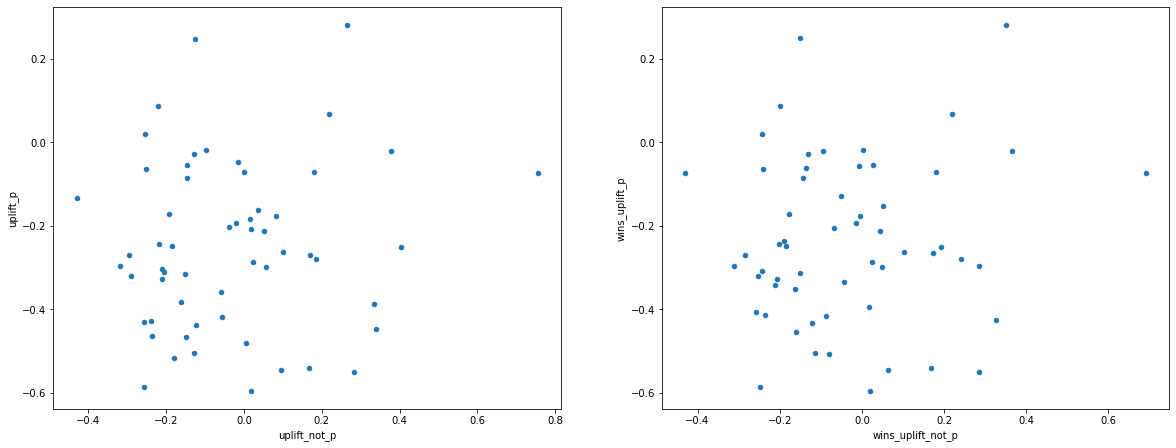

In [173]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 7.4))

data3.plot(kind = 'scatter', x = 'uplift_not_p', y = 'uplift_p', ax=axes[0])
data3.plot(kind = 'scatter', x = 'wins_uplift_not_p', y = 'wins_uplift_p', ax=axes[1])

print(stats.pearsonr(data3.uplift_not_p, data3.uplift_p))
print(stats.pearsonr(data3.wins_uplift_not_p, data3.wins_uplift_p))

In [174]:
data4 = FeatureStoreOfflineClient.run_athena_query_pandas("""
WITH first_logins     AS (
    SELECT user_id
         , MIN(meta_date) first_login
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start
    GROUP BY user_id
    )
   , login_stats      AS (
    SELECT log.user_id
         , log.meta_date
         , MAX(test_group)  AS test_group
         , MIN(first_login) AS first_login
         , MAX(CASE
                   WHEN first_operating_system = 'Android' THEN 'android'
                   WHEN first_operating_system = 'iOS' THEN 'apple'
                   ELSE 'na' END
        )                   AS os
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.session_start                        log
         INNER JOIN console.clean_abtest                                                  ab
                    ON log.user_id = ab.user_id
                        AND ab.meta_company_id = 'tinysoft-a9kwp'
                        AND ab.meta_project_id = 'heroes-magic-war-h2sln'
         LEFT JOIN  first_logins                                                          fl
                    ON log.user_id = fl.user_id
         LEFT JOIN  etl__tinysoft_a9kwp__heroes_magic_war_h2sln.geo_device_data           geo
                    ON log.user_id = geo.user_id
                        AND log.meta_date = geo.meta_date
         LEFT JOIN  analytics__tinysoft_a9kwp__heroes_magic_war_h2sln.user_exclusion_list uel
                    ON log.user_id = uel.account_id
                        AND log.meta_date BETWEEN uel.date_from AND uel.date_to
    WHERE uel.account_id IS NULL
    GROUP BY log.user_id
           , log.meta_date
    )
   , player_spend     AS (
    SELECT user_id
         , meta_date
         , COALESCE(offer, 'non_personalised')         AS offer
         , MAX(test_group)                             AS test_group
         , SUM(sum_in_app_purchase_event_value_in_usd) AS spend
    FROM etl__tinysoft_a9kwp__heroes_magic_war_h2sln.in_app_purchase payments
         INNER JOIN console.clean_abtest                             ab
                    USING (user_id)
         LEFT JOIN  console.tinysoft_offer_store_tmp                 os
                    ON payments.eventpar_product_id = os.offer
    WHERE (ab.meta_company_id = 'tinysoft-a9kwp')
      AND (ab.meta_project_id = 'heroes-magic-war-h2sln')
    GROUP BY user_id
           , meta_date
           , COALESCE(offer, 'non_personalised')
    )

   , win_ratio        AS (
    SELECT *
         , approx_percentile(spend, 0.99) OVER (partition BY meta_date, test_group) AS percentile_threshold
    FROM (
             SELECT user_id
                  , meta_date
                  , test_group
                  , SUM(spend) AS spend
             FROM player_spend
             GROUP BY user_id
                    , meta_date
                    , test_group
             )
    )

   , wins_spend_table AS (
    SELECT user_id
         , meta_date
         , player_spend.*
         , CASE
               WHEN player_spend.spend > percentile_threshold THEN percentile_threshold
               ELSE player_spend.spend END AS wins_spend
    FROM player_spend
         JOIN win_ratio USING (meta_date, user_id)
    )

   , user_level_data  AS (
    SELECT user_id
         , meta_date
         , first_login
         , COALESCE(spend, 0)      spend
         , COALESCE(wins_spend, 0) wins_spend
         , os
         , CASE
               WHEN test_group = 'P' THEN 1 -- 'personalized'
               WHEN test_group = 'C' THEN 0 -- 'control'
               ELSE 9 END          group_tag
         , 'Heroes Magic War'      client_name
         , CASE
               WHEN offer LIKE 'arena_offer%' THEN 'arena_offer'
               WHEN offer = 'non_personalised' THEN 'non_personalised'
        END                        offer
    FROM login_stats
         LEFT JOIN wins_spend_table USING (user_id, meta_date, test_group)
    WHERE first_login >= DATE '2023-01-01'
    )
   , t_out_np            AS (
    SELECT DATE_DIFF('day', first_login, meta_date)             dig
         , SUM(spend)                                           spend
         , SUM(wins_spend)                                      wins_spend
         , COUNT(DISTINCT user_id)                              n_users
         , COUNT(DISTINCT CASE WHEN spend > 0 THEN user_id END) n_payers
         , group_tag
         , 'non_personalised' offer
    FROM user_level_data
    WHERE offer = 'non_personalised' OR offer IS NULL
    GROUP BY DATE_DIFF('day', first_login, meta_date)
           , group_tag
    )
   , t_out_p            AS (
    SELECT DATE_DIFF('day', first_login, meta_date)             dig
         , SUM(spend)                                           spend
         , SUM(wins_spend)                                      wins_spend
         , COUNT(DISTINCT user_id)                              n_users
         , COUNT(DISTINCT CASE WHEN spend > 0 THEN user_id END) n_payers
         , group_tag
         , 'arena_offer' offer
    FROM user_level_data
    WHERE offer = 'arena_offer' OR offer IS NULL
    GROUP BY DATE_DIFF('day', first_login, meta_date)
           , group_tag
    )
SELECT *
FROM t_out_np
UNION
SELECT *
FROM t_out_p;
""")
data4.head()

DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:165.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:15403.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:7682265880|c


,dig,spend,wins_spend,n_users,n_payers,group_tag,offer
0,45,363.004214,363.004214,2084,17,0,non_personalised
1,42,729.960384,729.960384,2990,31,0,non_personalised
2,49,160.547875,160.547875,1398,9,0,non_personalised
3,29,534.950076,534.895533,2986,22,1,non_personalised
4,48,152.313882,152.313882,715,5,1,non_personalised


In [282]:
data4['arpu'] = data4.spend / data4.n_users
data4['wins_arpu'] = data4.wins_spend / data4.n_users
data4['arppu'] = data4.spend / data4.n_payers
data4['wins_arppu'] = data4.wins_spend / data4.n_payers

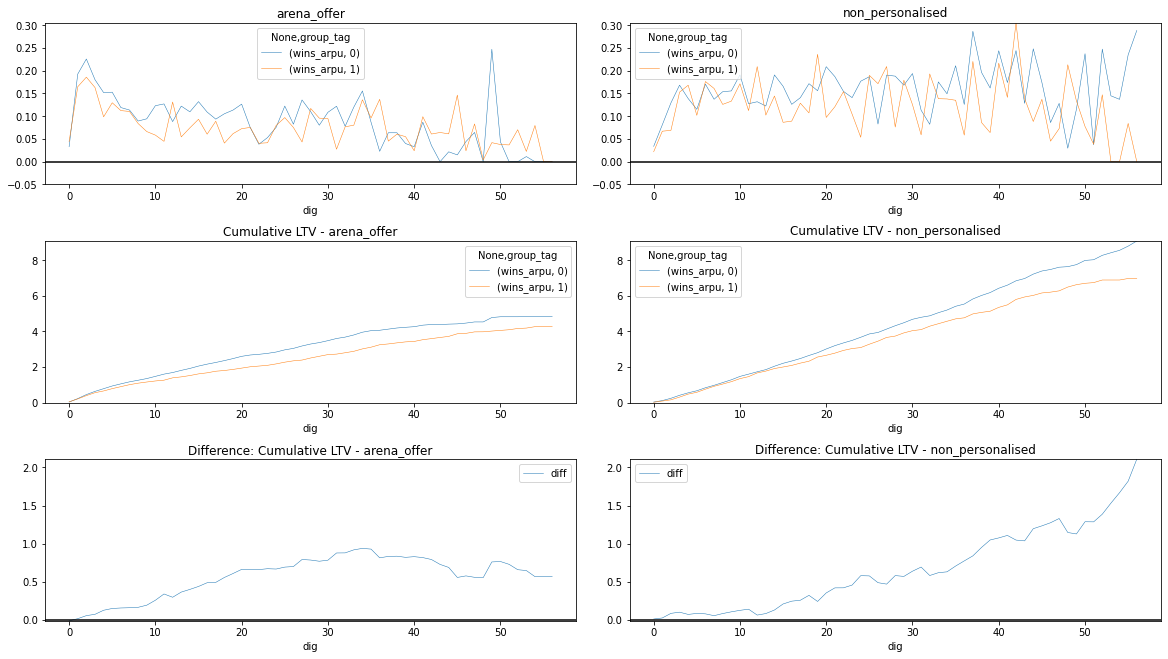

In [281]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(20,11))
plt.subplots_adjust(hspace = 0.35, wspace = 0.1)

temp_data_ao = data4[data4.offer == 'arena_offer'].pivot(index = "dig", columns = "group_tag", values = ["wins_arpu"])
temp_data_np = data4[data4.offer == 'non_personalised'].pivot(index = "dig", columns = "group_tag", values = ["wins_arpu"])
temp_data_ao.plot(ax = axes[0, 0], title = 'arena_offer', linewidth = 0.5,
                  ylim = [-0.05, pd.concat([temp_data_ao, temp_data_np]).unstack().max()])
temp_data_np.plot(ax = axes[0, 1], title = 'non_personalised', linewidth = 0.5,
                  ylim = [-0.05, pd.concat([temp_data_ao, temp_data_np]).unstack().max()])


temp_data_ao = temp_data_ao.cumsum()
temp_data_np = temp_data_np.cumsum()
temp_data_ao.plot(ax = axes[1, 0], title = 'Cumulative LTV - arena_offer', linewidth = 0.5,
                  ylim = [0, pd.concat([temp_data_ao, temp_data_np]).unstack().max()])
temp_data_np.plot(ax = axes[1, 1], title = 'Cumulative LTV - non_personalised', linewidth = 0.5,
                  ylim = [0, pd.concat([temp_data_ao, temp_data_np]).unstack().max()])


temp_data_ao['diff']=temp_data_ao['wins_arpu'][0]-temp_data_ao['wins_arpu'][1]
temp_data_np['diff']=temp_data_np['wins_arpu'][0]-temp_data_np['wins_arpu'][1]
temp_data_ao['diff'].plot(ax = axes[2, 0], title = 'Difference: Cumulative LTV - arena_offer', linewidth = 0.5, legend = True,
                          ylim = [min([min(temp_data_ao['diff']), min(temp_data_np['diff'])]), max([max(temp_data_ao['diff']), max(temp_data_np['diff'])])])
temp_data_np['diff'].plot(ax = axes[2, 1], title = 'Difference: Cumulative LTV - non_personalised', linewidth = 0.5, legend = True,
                          ylim = [min([min(temp_data_ao['diff']), min(temp_data_np['diff'])]), max([max(temp_data_ao['diff']), max(temp_data_np['diff'])])])

axes[0, 0].axhline(y = 0, color = 'black', linewidth = 1.5)
axes[2, 0].axhline(y = 0, color = 'black', linewidth = 1.5)
axes[0, 1].axhline(y = 0, color = 'black', linewidth = 1.5)
axes[2, 1].axhline(y = 0, color = 'black', linewidth = 1.5)